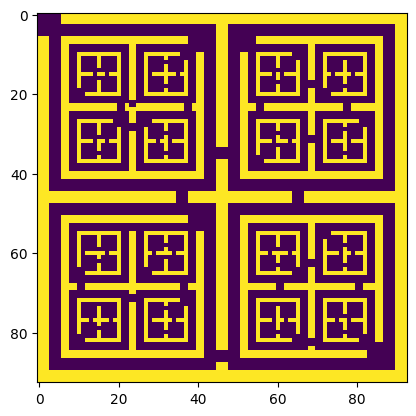

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import hypll
from hypll.manifolds.poincare_ball import Curvature, PoincareBall
from hypll.optim import RiemannianAdam
import hypll.nn as hnn
from hypll.tensors import TangentTensor

from pyramid import create_pyramid
from continuous_maze import bfs, gen_traj, plot_traj, ContinuousGridEnvironment, TrajectoryDataset, LabelDataset
from hyperbolic_networks import HyperbolicMLP, hyperbolic_infoNCE_loss, manifold_map
from networks import StateActionEncoder, StateEncoder, infoNCE_loss

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(device)

cpu


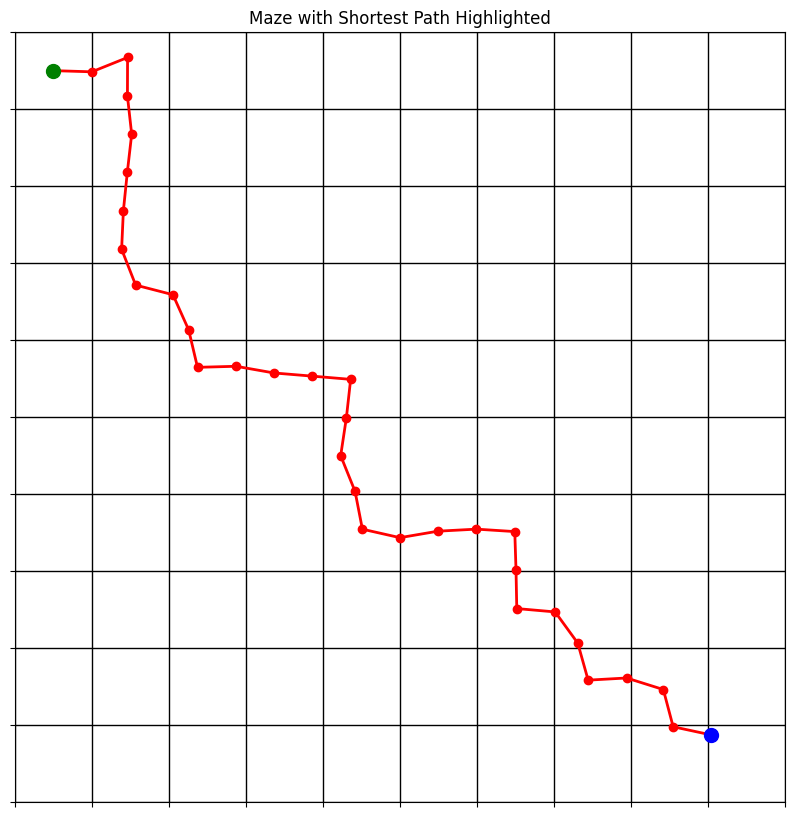

In [3]:
# define maze
maze = np.zeros((10, 10))
path = gen_traj(maze, (0, 0), (9, 9))
plot_traj(maze, [x[0] for x in path])

In [4]:
# configs
batch_size = 32
embedding_dim = 16

dataset = TrajectoryDataset(maze, 5000, embedding_dim=2, num_negatives=10)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [5]:
def evaluate(maze, num_trials, encoder1, encoder2, manifold, max_steps=100, hyperbolic=False, eps=10.):
    valid_indices = np.argwhere(maze == 0)
    np.random.shuffle(valid_indices)
    
    results = []
    for i in range(num_trials):
        with torch.no_grad():
            start, end = np.random.randint(0, len(valid_indices), size=2)
            start = tuple(valid_indices[start])
            end = tuple(valid_indices[end])
            
            goal = torch.tensor(end).to(torch.float32).to(device).unsqueeze(0)
            if hyperbolic:
                goal = manifold_map(goal, manifold=manifold)
            goal = encoder2(goal)
            
            env = ContinuousGridEnvironment(maze, start, {})
            
            cur_pos = env.agent_position
            # print(f'a: {cur_pos}')
            
            def reached(cur_pos, goal_pos):
                # print(f'cur pos: {cur_pos}')
                cur_pos = (int(cur_pos[0]), int(cur_pos[1]))
                goal_pos = (int(goal_pos[0]), int(goal_pos[1]))
                return cur_pos == goal_pos
            
            def step():
                activations = []
                angles = torch.linspace(0., 2 * torch.pi, 16)
                for a in angles:
                    action = torch.tensor([torch.sin(a), torch.cos(a)])
                    cur = torch.tensor([cur_pos[0], cur_pos[1], torch.sin(a), torch.cos(a)]).to(torch.float32)
                    if hyperbolic:
                        cur = manifold_map(cur, manifold)
                    cur = encoder1(cur)

                    # MANIFOLD EVAL
                    if hyperbolic:
                        activations.append((action, -manifold.dist(x=cur, y=goal)))
                    else:
                        activations.append((action, -torch.norm(cur - goal)))

                best_action = activations[np.argmax([x[1].detach().numpy() for x in activations])][0]
                angle = np.arctan2(best_action[0], best_action[1]) + np.random.normal() * eps * (2 * np.pi / 360)
                best_action = torch.tensor(np.array([np.sin(angle), np.cos(angle)]))
                env.move_agent(best_action)
                # print(f'agent position: {env.agent_position}')
                
            steps = 0
            while not reached(env.agent_position, end):
                if steps > max_steps:
                    break
                step()
                steps += 1
            
            # print(reached(env.agent_position, end))
            # print(f'start: {start}, end: {end}, steps: {steps}')
            results.append((reached(env.agent_position, end), steps))
    return results
    

In [6]:
def train(num_epochs, maze, dataloader, encoder_mod1, encoder_mod2, optimizer, hyperbolic=False, manifold=None, eval_trials=100, max_steps=100):
    print(f'is hyperbolic: {hyperbolic}')
    # Training loop
    accuracies = []
    losses = []
    failures = []
    for epoch in range(num_epochs):
        total_loss = 0
        for anchor, positive, negatives in dataloader:
            # (s,a) <-> (s)
            anchor = torch.tensor(anchor).to(torch.float32).to(device)
            positive = torch.tensor(positive).to(torch.float32).to(device)
            negatives = torch.tensor(negatives).to(torch.float32).to(device)
            
            if hyperbolic:
                m_anchor = manifold_map(anchor, manifold)
                m_positive = manifold_map(positive, manifold)
                m_negatives = manifold_map(negatives, manifold)
            else:
                m_anchor = anchor
                m_positive = positive
                m_negatives = negatives

            # print(f'negatives shape: {m_negatives.shape}')
            anchor_enc = encoder_mod1(m_anchor) # takes state, action tuple
            positive_enc = encoder_mod2(m_positive) # takes state
            negatives_enc = encoder_mod2(m_negatives)

            positive_action = anchor[:,[2,3]]
            cur_state = anchor[:,[0,1]]
            angle = torch.arctan2(anchor[:,2], anchor[:,3])

            negative_actions = (angle + torch.pi)[:,None] + (torch.rand(num_negatives)[None,:] - 0.5) * (3 * torch.pi / 2)
            negative_dirs = torch.stack([torch.sin(negative_actions), torch.cos(negative_actions)]).moveaxis(0, -1)
            # print(f'negative actions shape: {negative_actions.shape}')
            # print(negative_dirs.shape)
            negative_full = torch.cat((cur_state.unsqueeze(1).expand(-1, num_negatives, -1), negative_dirs), dim=-1).to(device)
            
            if hyperbolic:
                m_negative_full = manifold_map(negative_full, manifold)
            else:
                m_negative_full = negative_full

            # print(negative_full.shape)
            neg_action_enc = encoder_mod1(m_negative_full)
            # print(f'positive_enc: {positive_enc.shape}, anchor: {anchor_enc.shape}, neg_action_enc: {neg_action_enc.shape}')
            
            if hyperbolic:
                action_loss = hyperbolic_infoNCE_loss(positive_enc, anchor_enc, neg_action_enc, temperature, manifold=manifold)
                future_loss = hyperbolic_infoNCE_loss(anchor_enc, positive_enc, negatives_enc, temperature, manifold=manifold)
            else:
                action_loss = infoNCE_loss(positive_enc, anchor_enc, neg_action_enc, temperature, metric_type=1)
                future_loss = infoNCE_loss(anchor_enc, positive_enc, negatives_enc, temperature, metric_type=1)
            
            loss = action_loss + future_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        loss = total_loss / len(dataloader)
        evals = evaluate(maze, eval_trials, encoder_mod1, encoder_mod2, manifold, max_steps=max_steps, hyperbolic=hyperbolic)
        acc = np.mean([x[1] for x in evals])
        fail = np.mean([x[0] for x in evals])
        losses.append(loss)
        accuracies.append(acc)
        failures.append(fail)
        print(f'Epoch {epoch+1}, Loss: {loss}, Mean Step(s) to Goal: {acc}, Failure %: {fail}')
    return losses, accuracies, failures
        


In [7]:
def visualize_path(start, end, encoder_mod1, encoder_mod2, manifold):
    with torch.no_grad():
        start = torch.tensor([9.5, 9.5])
        vec2 = None

        goal = manifold_map(torch.tensor([6., 4.]), manifold)
        vec2 = encoder_mod2(goal)
        eps = 30

        env = ContinuousGridEnvironment(maze, start, {})
        fig, ax = plt.subplots()

        def update(i):
            cur_pos = env.agent_position

            activations = []
            angles = torch.linspace(0., 2 * torch.pi, 16)
            for a in angles:
                action = torch.tensor([torch.sin(a), torch.cos(a)])
                vec1 = torch.tensor([cur_pos[0], cur_pos[1], torch.sin(a), torch.cos(a)]).to(torch.float32)
                vec1 = manifold_map(vec1, manifold)
                vec1 = encoder_mod1(vec1)

                # MANIFOLD EVAL
                activations.append((action, -manifold.dist(x=vec1, y=vec2)))

            best_action = activations[np.argmax([x[1].detach().numpy() for x in activations])][0]
            angle = np.arctan2(best_action[0], best_action[1]) + np.random.normal() * eps * (2 * np.pi / 360)
            best_action = torch.tensor(np.array([np.sin(angle), np.cos(angle)]))
            env.move_agent(best_action)

            ax.clear()
            env.display(ax=ax)

        # Set animation display in Jupyter notebook and figure resolution
        plt.rcParams["animation.html"] = "jshtml"
        plt.rcParams['figure.dpi'] = 150

        # Create the animation
        ani = FuncAnimation(fig, update, frames=50, interval=50, repeat=False)

    return ani

## Train

In [8]:
num_epochs = 32
temperature = 0.1
batch_size = 32
num_negatives = 11
# Initialize encoders
metric_type = 0
eval_type = 'dot'
manifold = PoincareBall(c=Curvature(value=0.1, requires_grad=True))

if metric_type == 1:
    eval_type = 'dist'


In [9]:
def train_opt(hyperbolic, num_epochs, max_steps, eval_trials):
    manifold = PoincareBall(c=Curvature(value=0.1, requires_grad=True))
    if hyperbolic:
        encoder1 = HyperbolicMLP(in_features=4, out_features=embedding_dim, manifold=manifold.to(device))
        encoder2 = HyperbolicMLP(in_features=2, out_features=embedding_dim, manifold=manifold.to(device))

        optimizer = RiemannianAdam(list(encoder1.parameters()) + list(encoder2.parameters()), lr=0.001)
    else:
        encoder1 = StateActionEncoder(embedding_dim)
        encoder2 = StateEncoder(embedding_dim)

        optimizer = optim.Adam(list(encoder1.parameters()) + list(encoder2.parameters()), lr=0.001)

    losses, accs, failures = train(num_epochs, maze, dataloader, encoder1, encoder2, optimizer, hyperbolic=hyperbolic, manifold=manifold, eval_trials=eval_trials, max_steps=max_steps)
    
    return losses, accs, failures

def plot_results(epochs, losses, accs, failures):
    # Create subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Plot for losses
    axs[0].plot(epochs, losses, marker='o', linestyle='-', color='b')
    axs[0].set_title('Losses over Epochs')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Losses')

    # Plot for accuracies
    axs[1].plot(epochs, accs, marker='o', linestyle='-', color='g')
    axs[1].set_title('Avg Path Length over Epochs')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Path Length')

    # Plot for failures
    axs[2].plot(epochs, failures, marker='o', linestyle='-', color='r')
    axs[2].set_title('Failures over Epochs')
    axs[2].set_xlabel('Epochs')
    axs[2].set_ylabel('Failures Percentage')

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()

/home/yongweic/.conda/envs/hypll/lib/python3.10/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/yongweic/.conda/envs/hypll/lib/python3.10/site-packages/torch/_compile.py:24: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  return torch._dynamo.disable(fn, recursive)(*args, **kwargs)
/tmp/ipykernel_3318240/1455753018.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  anchor = torch.tensor(anchor).to(torch.float32).to(device)
/tmp/ipykernel_3318240/1455753018.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than t

is hyperbolic: True
Epoch 1, Loss: 4.518896464329616, Mean Step(s) to Goal: 84.15, Failure %: 0.18
Epoch 2, Loss: 4.203606907729131, Mean Step(s) to Goal: 86.38, Failure %: 0.16
Epoch 3, Loss: 4.068009218592553, Mean Step(s) to Goal: 75.52, Failure %: 0.27
Epoch 4, Loss: 3.915722604010515, Mean Step(s) to Goal: 78.27, Failure %: 0.24
Epoch 5, Loss: 3.7780717664463506, Mean Step(s) to Goal: 77.82, Failure %: 0.25
Epoch 6, Loss: 3.6210056702802134, Mean Step(s) to Goal: 67.96, Failure %: 0.35
Epoch 7, Loss: 3.4460708366078174, Mean Step(s) to Goal: 65.08, Failure %: 0.39
Epoch 8, Loss: 3.343323520794036, Mean Step(s) to Goal: 70.86, Failure %: 0.33
Epoch 9, Loss: 3.303788078818352, Mean Step(s) to Goal: 60.48, Failure %: 0.43
Epoch 10, Loss: 3.2453259844688853, Mean Step(s) to Goal: 71.4, Failure %: 0.32
Epoch 11, Loss: 3.214757671781406, Mean Step(s) to Goal: 63.85, Failure %: 0.4
Epoch 12, Loss: 3.169181945217643, Mean Step(s) to Goal: 64.58, Failure %: 0.39
Epoch 13, Loss: 3.102012101

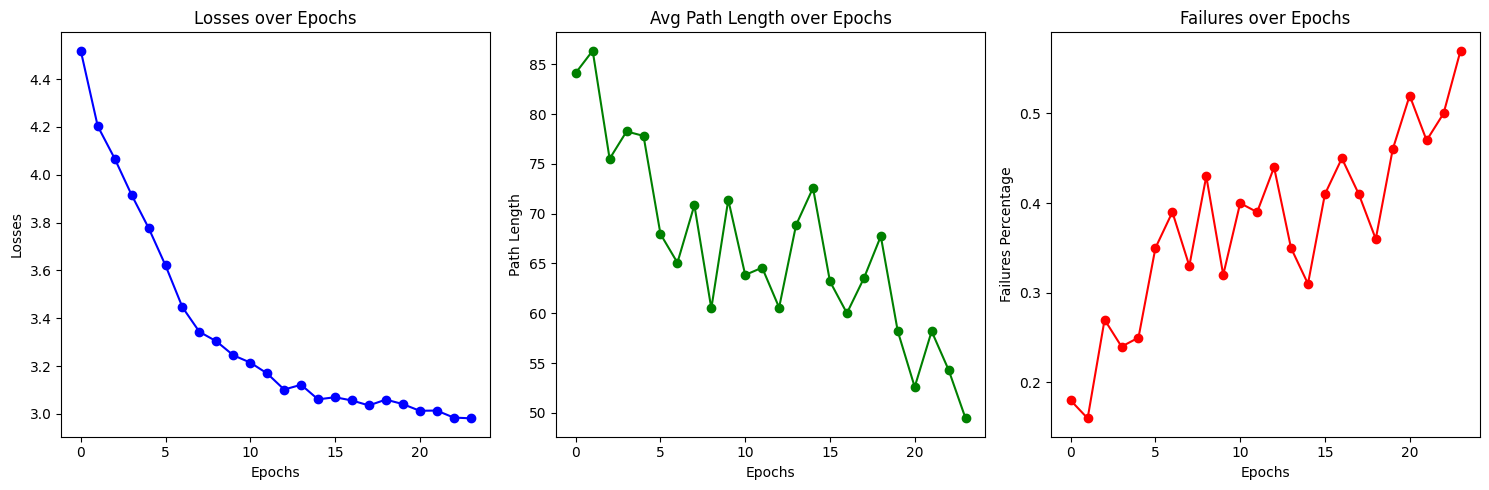

In [10]:
losses, accs, failures = train_opt(hyperbolic=True, num_epochs=24, max_steps=100, eval_trials=100)

plot_results([i for i in range(len(losses))], losses, accs, failures)